## Libraries - Packages

In [1]:
import json
import pandas as pd
import networkx as nx
import os
from tqdm import tqdm
from os.path import join
from data_handler import FeatureEngineering

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn.init import kaiming_uniform_
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2
import random
from torch.utils.data import TensorDataset, DataLoader


## Global Variables

In [2]:
input_path = join("io", "input")
output_path = join("io", "output")
experiments_path = join("io", "experiments")
metrics_path = join(experiments_path, "metrics")
plots_path = join(experiments_path, "plots")

core_features = ['node_id', 'ETA_curr']

calendar_features = ['sin_hour','cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month','sin_dayofmonth', 'cos_dayofmonth', 
                     'sin_weekofyear', 'cos_weekofyear', 'sin_quarter_hour', 'cos_quarter_hour']

rolling_avg_features = ['rolling_avg_4h', 'rolling_avg_12h', 'rolling_avg_68h', 'rolling_avg_476h', 'rolling_avg_20240h']

lag_features = ['lag1h', 'lag4h', 'lag476h', 'lag20240h']

feature_cols = core_features + calendar_features + rolling_avg_features + lag_features

edges_df = pd.read_csv(join(output_path, "interm_network_edges.csv"), encoding='utf-8', sep=',')

## General Functions

In [3]:
def save_dict(path, filename, data):
    with open(path + '/' + filename + '.json', 'w') as f:
        json.dump(data, f)
        

In [4]:
def load_dict(path, filename):
    with open(path + '/' + filename + '.json', 'r') as f:
        data_loaded = json.load(f)
    return data_loaded


In [5]:
def smooth_curve(points, factor=0.6):#     
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [6]:
def plot_specific_distribution(forecast_df, node_id, timestamp, plots_path):
    # Filter the DataFrame for the specified node_id and timestamp
    specific_forecast = forecast_df[(forecast_df['node_id'] == node_id) & (forecast_df['timestamp'] == timestamp)]

    if specific_forecast.empty:
        print(f"No data available for node_id {node_id} at timestamp {timestamp}.")
        return

    # Extract mean and log_var values
    mean_val = specific_forecast['mean'].values[0]
    log_var_val = specific_forecast['log_var'].values[0]

    # Calculate the standard deviation from log_var
    std_dev = np.sqrt(np.exp(log_var_val))

    # Create a range of values for which to plot the normal distribution
    x = np.linspace(mean_val - 3*std_dev, mean_val + 3*std_dev, 100)

    # Plot the normal distribution
    plt.figure(figsize=(8, 4))
    plt.plot(x, norm.pdf(x, mean_val, std_dev), label=f'Normal Dist. (Mean={mean_val:.2f}, SD={std_dev:.2f})')
    plt.title(f'Distribution for Node ID {node_id} at {timestamp}')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.savefig(plots_path + "/traffic_speed_distribution.pdf")
    plt.show()

## Plot Experiments with Neural Network Architecture

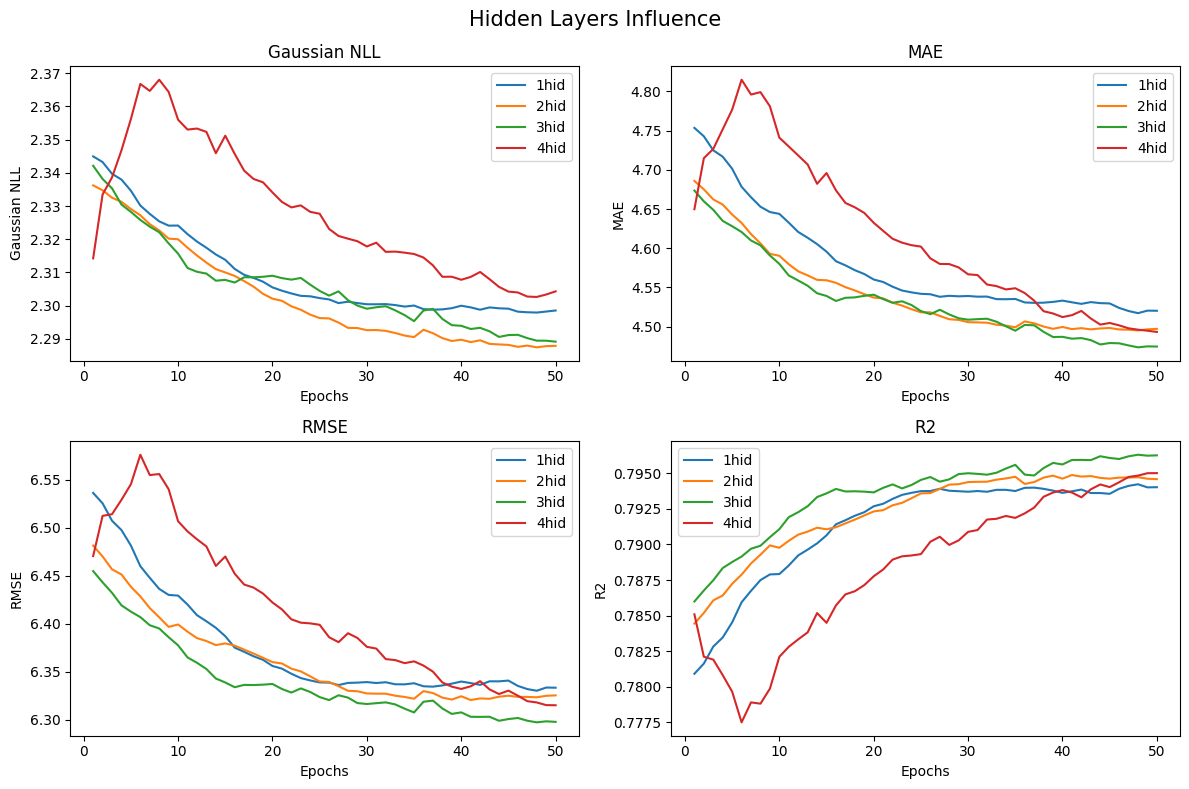

In [37]:
factor =  0.7
st=10

m1 = load_dict(metrics_path, 'experiment_model_A3TGCN2')
m2 = load_dict(metrics_path, 'experiment_model_A3TGCN2_1hid')
m3 = load_dict(metrics_path, 'experiment_model_A3TGCN2_2hid')
m4 = load_dict(metrics_path, 'experiment_model_A3TGCN2_3hid')
m5 = load_dict(metrics_path, 'experiment_model_A3TGCN2_4hid')

smooth_loss_val_A3TGCN2 = smooth_curve(m1['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_A3TGCN2_1hid = smooth_curve(m2['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_A3TGCN2_2hid = smooth_curve(m3['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_A3TGCN2_3hid = smooth_curve(m4['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_A3TGCN2_4hid = smooth_curve(m5['eval_nll_loss_ls'][st:], factor)

smooth_mae_val_A3TGCN2 = smooth_curve(m1['eval_mae_ls'][st:], factor)
smooth_mae_val_A3TGCN2_1hid = smooth_curve(m2['eval_mae_ls'][st:], factor)
smooth_mae_val_A3TGCN2_2hid = smooth_curve(m3['eval_mae_ls'][st:], factor)
smooth_mae_val_A3TGCN2_3hid = smooth_curve(m4['eval_mae_ls'][st:], factor)
smooth_mae_val_A3TGCN2_4hid = smooth_curve(m5['eval_mae_ls'][st:], factor)

smooth_mse_val_A3TGCN2 = smooth_curve(m1['eval_rmse_ls'][st:], factor)
smooth_mse_val_A3TGCN2_1hid = smooth_curve(m2['eval_rmse_ls'][st:], factor)
smooth_mse_val_A3TGCN2_2hid = smooth_curve(m3['eval_rmse_ls'][st:], factor)
smooth_mse_val_A3TGCN2_3hid = smooth_curve(m4['eval_rmse_ls'][st:], factor)
smooth_mse_val_A3TGCN2_4hid = smooth_curve(m5['eval_rmse_ls'][st:], factor)

smooth_r2_val_A3TGCN2 = smooth_curve(m1['eval_r2_ls'][st:], factor)
smooth_r2_val_A3TGCN2_1hid = smooth_curve(m2['eval_r2_ls'][st:], factor)
smooth_r2_val_A3TGCN2_2hid = smooth_curve(m3['eval_r2_ls'][st:], factor)
smooth_r2_val_A3TGCN2_3hid = smooth_curve(m4['eval_r2_ls'][st:], factor)
smooth_r2_val_A3TGCN2_4hid = smooth_curve(m5['eval_r2_ls'][st:], factor)

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
fig.suptitle('Hidden Layers Influence', fontsize=15)
# Plot the first metric on the top-left subplot
axs[0, 0].plot(range(1, len(smooth_loss_val_A3TGCN2_1hid) + 1), smooth_loss_val_A3TGCN2_1hid, label='1hid')
axs[0, 0].plot(range(1, len(smooth_loss_val_A3TGCN2_2hid) + 1), smooth_loss_val_A3TGCN2_2hid, label='2hid')
axs[0, 0].plot(range(1, len(smooth_loss_val_A3TGCN2_3hid) + 1), smooth_loss_val_A3TGCN2_3hid, label='3hid')
axs[0, 0].plot(range(1, len(smooth_loss_val_A3TGCN2_4hid) + 1), smooth_loss_val_A3TGCN2_4hid, label='4hid')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Gaussian NLL')
axs[0, 0].set_title('Gaussian NLL')
axs[0, 0].legend()
# Plot the second metric on the top-right subplot
axs[0, 1].plot(range(1, len(smooth_mae_val_A3TGCN2_1hid) + 1), smooth_mae_val_A3TGCN2_1hid, label='1hid')
axs[0, 1].plot(range(1, len(smooth_mae_val_A3TGCN2_2hid) + 1), smooth_mae_val_A3TGCN2_2hid, label='2hid')
axs[0, 1].plot(range(1, len(smooth_mae_val_A3TGCN2_3hid) + 1), smooth_mae_val_A3TGCN2_3hid, label='3hid')
axs[0, 1].plot(range(1, len(smooth_mae_val_A3TGCN2_4hid) + 1), smooth_mae_val_A3TGCN2_4hid, label='4hid')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].legend()
# Plot the third metric on the bottom-left subplot
axs[1, 0].plot(range(1, len(smooth_mse_val_A3TGCN2_1hid) + 1), smooth_mse_val_A3TGCN2_1hid, label='1hid')
axs[1, 0].plot(range(1, len(smooth_mse_val_A3TGCN2_2hid) + 1), smooth_mse_val_A3TGCN2_2hid, label='2hid')
axs[1, 0].plot(range(1, len(smooth_mse_val_A3TGCN2_3hid) + 1), smooth_mse_val_A3TGCN2_3hid, label='3hid')
axs[1, 0].plot(range(1, len(smooth_mse_val_A3TGCN2_4hid) + 1), smooth_mse_val_A3TGCN2_4hid, label='4hid')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_title('RMSE')
axs[1, 0].legend()
# Plot the fourth metric on the bottom-right subplot
axs[1, 1].plot(range(1, len(smooth_r2_val_A3TGCN2_1hid) + 1), smooth_r2_val_A3TGCN2_1hid, label='1hid')
axs[1, 1].plot(range(1, len(smooth_r2_val_A3TGCN2_2hid) + 1), smooth_r2_val_A3TGCN2_2hid, label='2hid')
axs[1, 1].plot(range(1, len(smooth_r2_val_A3TGCN2_3hid) + 1), smooth_r2_val_A3TGCN2_3hid, label='3hid')
axs[1, 1].plot(range(1, len(smooth_r2_val_A3TGCN2_4hid) + 1), smooth_r2_val_A3TGCN2_4hid, label='4hid')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('R2')
axs[1, 1].set_title('R2')
axs[1, 1].legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig(plots_path + "/hidden_layers_influence.pdf")
plt.show()



## Plot Experiments with Epochs Influence

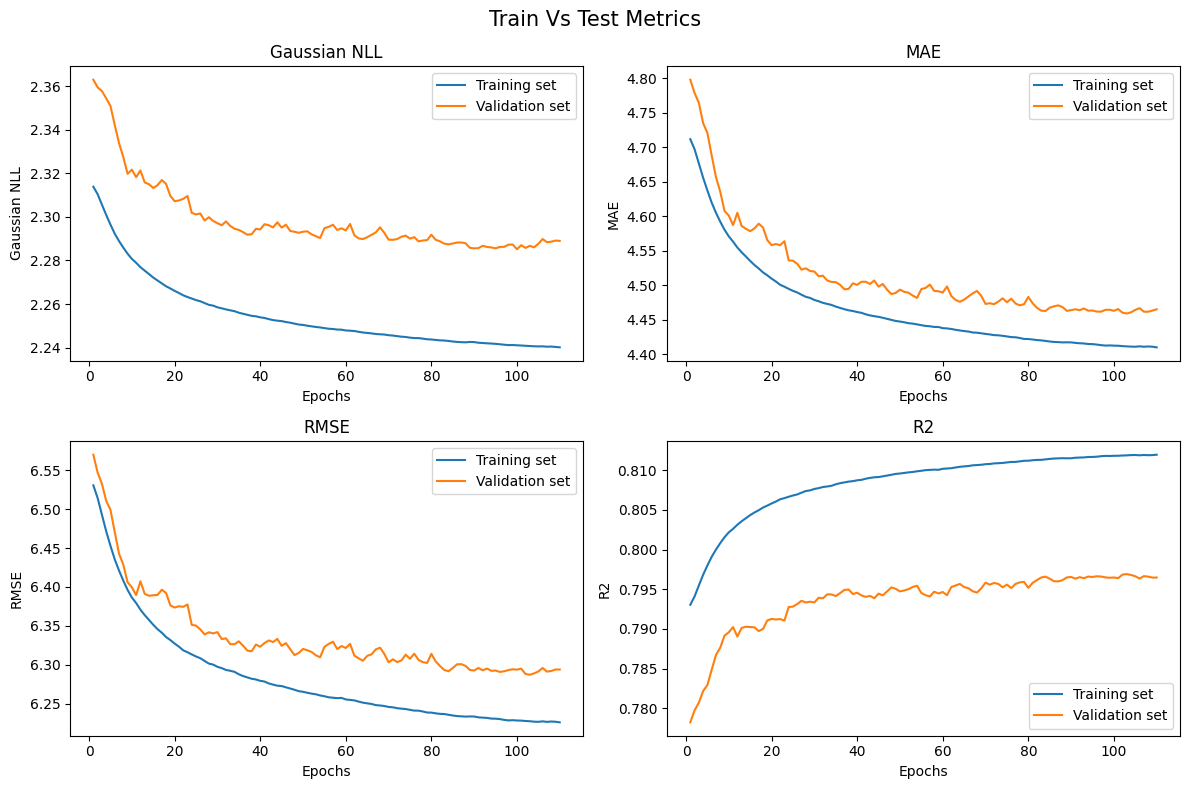

In [8]:
factor =  0.5
st = 10
metrics = load_dict(metrics_path, 'experiment_epochs_120')
smooth_loss_train = smooth_curve(metrics['train_nll_loss_ls'][st:], factor)
smooth_loss_val = smooth_curve(metrics['eval_nll_loss_ls'][st:], factor)
smooth_mae_train = smooth_curve(metrics['train_mae_ls'][st:], factor)
smooth_mae_val = smooth_curve(metrics['eval_mae_ls'][st:], factor)
smooth_mse_train = smooth_curve(metrics['train_rmse_ls'][st:], factor)
smooth_mse_val = smooth_curve(metrics['eval_rmse_ls'][st:], factor)
smooth_r2_train = smooth_curve(metrics['train_r2_ls'][st:], factor)
smooth_r2_val = smooth_curve(metrics['eval_r2_ls'][st:], factor)

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
fig.suptitle('Train Vs Test Metrics', fontsize=15)
# Plot the first metric on the top-left subplot
axs[0, 0].plot(range(1, len(smooth_loss_train) + 1), smooth_loss_train, label='Training set')
axs[0, 0].plot(range(1, len(smooth_loss_val) + 1), smooth_loss_val, label='Validation set')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Gaussian NLL')
axs[0, 0].set_title('Gaussian NLL')
axs[0, 0].legend()
# Plot the second metric on the top-right subplot
axs[0, 1].plot(range(1, len(smooth_mae_train) + 1), smooth_mae_train,label='Training set')
axs[0, 1].plot(range(1, len(smooth_mae_val) + 1), smooth_mae_val, label='Validation set')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].legend()
# Plot the third metric on the bottom-left subplot
axs[1, 0].plot(range(1, len(smooth_mse_train) + 1), smooth_mse_train,label='Training set')
axs[1, 0].plot(range(1, len(smooth_mse_val) + 1), smooth_mse_val, label='Validation set')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_title('RMSE')
axs[1, 0].legend()
# Plot the fourth metric on the bottom-right subplot
axs[1, 1].plot(range(1, len(smooth_r2_train) + 1), smooth_r2_train,label='Training set')
axs[1, 1].plot(range(1, len(smooth_r2_val) + 1), smooth_r2_val, label='Validation set')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('R2')
axs[1, 1].set_title('R2')
axs[1, 1].legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig(plots_path + "/epochs_influence.pdf")
plt.show()

## Plot Experiments with Batch Size

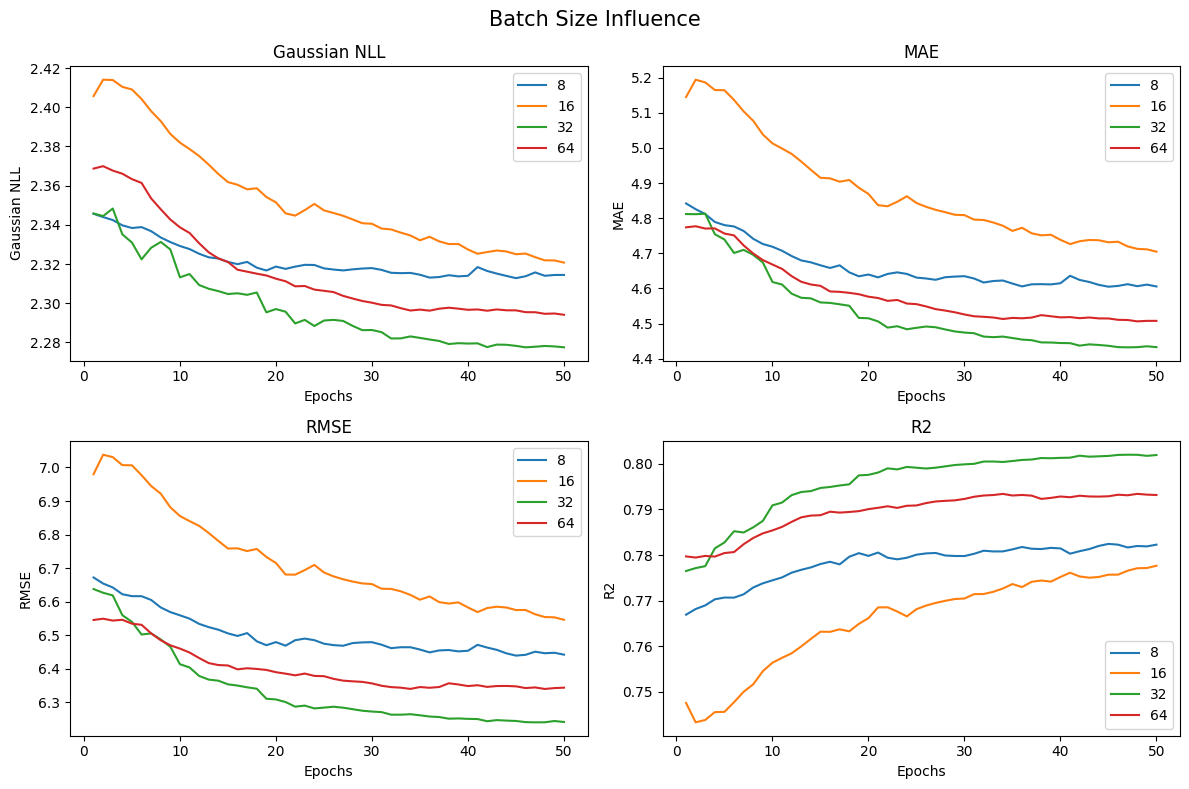

In [9]:
factor =  0.7
st=10

m1 = load_dict(metrics_path, 'experiment_batch_size_8')
m2 = load_dict(metrics_path, 'experiment_batch_size_16')
m3 = load_dict(metrics_path, 'experiment_batch_size_32')
m4 = load_dict(metrics_path, 'experiment_batch_size_64')


smooth_loss_val_1 = smooth_curve(m1['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_2 = smooth_curve(m2['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_3 = smooth_curve(m3['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_4 = smooth_curve(m4['eval_nll_loss_ls'][st:], factor)

smooth_mae_val_1 = smooth_curve(m1['eval_mae_ls'][st:], factor)
smooth_mae_val_2 = smooth_curve(m2['eval_mae_ls'][st:], factor)
smooth_mae_val_3 = smooth_curve(m3['eval_mae_ls'][st:], factor)
smooth_mae_val_4 = smooth_curve(m4['eval_mae_ls'][st:], factor)

smooth_mse_val_1 = smooth_curve(m1['eval_rmse_ls'][st:], factor)
smooth_mse_val_2 = smooth_curve(m2['eval_rmse_ls'][st:], factor)
smooth_mse_val_3 = smooth_curve(m3['eval_rmse_ls'][st:], factor)
smooth_mse_val_4 = smooth_curve(m4['eval_rmse_ls'][st:], factor)

smooth_r2_val_1 = smooth_curve(m1['eval_r2_ls'][st:], factor)
smooth_r2_val_2 = smooth_curve(m2['eval_r2_ls'][st:], factor)
smooth_r2_val_3 = smooth_curve(m3['eval_r2_ls'][st:], factor)
smooth_r2_val_4 = smooth_curve(m4['eval_r2_ls'][st:], factor)



fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
fig.suptitle('Batch Size Influence', fontsize=15)
# Plot the first metric on the top-left subplot
axs[0, 0].plot(range(1, len(smooth_loss_val_1) + 1), smooth_loss_val_1, label='8')
axs[0, 0].plot(range(1, len(smooth_loss_val_2) + 1), smooth_loss_val_2, label='16')
axs[0, 0].plot(range(1, len(smooth_loss_val_4) + 1), smooth_loss_val_4, label='32')
axs[0, 0].plot(range(1, len(smooth_loss_val_3) + 1), smooth_loss_val_3, label='64')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Gaussian NLL')
axs[0, 0].set_title('Gaussian NLL')
axs[0, 0].legend()
# Plot the second metric on the top-right subplot
axs[0, 1].plot(range(1, len(smooth_mae_val_1) + 1), smooth_mae_val_1, label='8')
axs[0, 1].plot(range(1, len(smooth_mae_val_2) + 1), smooth_mae_val_2, label='16')
axs[0, 1].plot(range(1, len(smooth_mae_val_4) + 1), smooth_mae_val_4, label='32')
axs[0, 1].plot(range(1, len(smooth_mae_val_3) + 1), smooth_mae_val_3, label='64')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].legend()
# Plot the third metric on the bottom-left subplot
axs[1, 0].plot(range(1, len(smooth_mse_val_1) + 1), smooth_mse_val_1, label='8')
axs[1, 0].plot(range(1, len(smooth_mse_val_2) + 1), smooth_mse_val_2, label='16')
axs[1, 0].plot(range(1, len(smooth_mse_val_4) + 1), smooth_mse_val_4, label='32')
axs[1, 0].plot(range(1, len(smooth_mse_val_3) + 1), smooth_mse_val_3, label='64')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_title('RMSE')
axs[1, 0].legend()
# Plot the fourth metric on the bottom-right subplot
axs[1, 1].plot(range(1, len(smooth_r2_val_1) + 1), smooth_r2_val_1, label='8')
axs[1, 1].plot(range(1, len(smooth_r2_val_2) + 1), smooth_r2_val_2, label='16')
axs[1, 1].plot(range(1, len(smooth_r2_val_4) + 1), smooth_r2_val_4, label='32')
axs[1, 1].plot(range(1, len(smooth_r2_val_3) + 1), smooth_r2_val_3, label='64')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('R2')
axs[1, 1].set_title('R2')
axs[1, 1].legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig(plots_path + "/batch_size_influence.pdf")
plt.show()



## Plot Experiments with Learning Rate

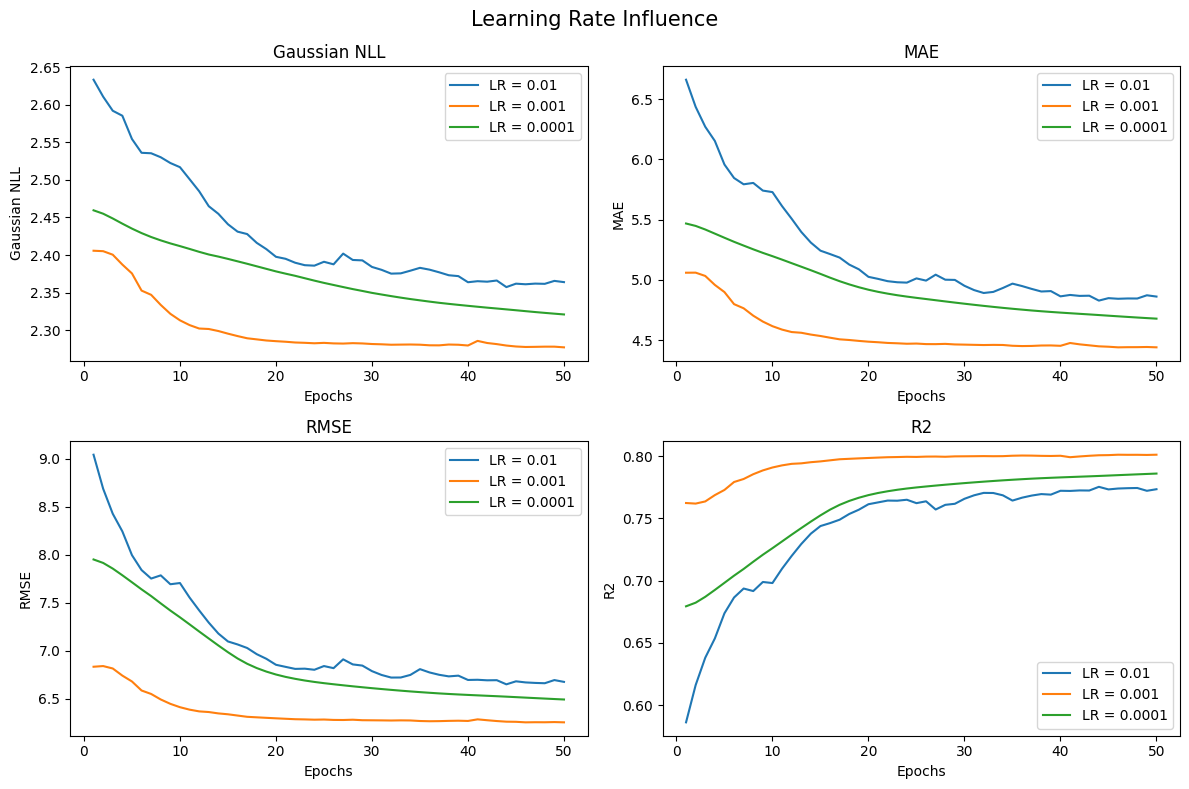

In [10]:
factor =  0.7
st=10

m1 = load_dict(metrics_path, 'experiment_learning_rate_0.01')
m2 = load_dict(metrics_path, 'experiment_learning_rate_0.001')
m3 = load_dict(metrics_path, 'experiment_learning_rate_0.0001')


smooth_loss_val_1 = smooth_curve(m1['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_2 = smooth_curve(m2['eval_nll_loss_ls'][st:], factor)
smooth_loss_val_3 = smooth_curve(m3['eval_nll_loss_ls'][st:], factor)


smooth_mae_val_1 = smooth_curve(m1['eval_mae_ls'][st:], factor)
smooth_mae_val_2 = smooth_curve(m2['eval_mae_ls'][st:], factor)
smooth_mae_val_3 = smooth_curve(m3['eval_mae_ls'][st:], factor)


smooth_mse_val_1 = smooth_curve(m1['eval_rmse_ls'][st:], factor)
smooth_mse_val_2 = smooth_curve(m2['eval_rmse_ls'][st:], factor)
smooth_mse_val_3 = smooth_curve(m3['eval_rmse_ls'][st:], factor)


smooth_r2_val_1 = smooth_curve(m1['eval_r2_ls'][st:], factor)
smooth_r2_val_2 = smooth_curve(m2['eval_r2_ls'][st:], factor)
smooth_r2_val_3 = smooth_curve(m3['eval_r2_ls'][st:], factor)


fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
fig.suptitle('Learning Rate Influence', fontsize=15)
# Plot the first metric on the top-left subplot
axs[0, 0].plot(range(1, len(smooth_loss_val_1) + 1), smooth_loss_val_1, label='LR = 0.01')
axs[0, 0].plot(range(1, len(smooth_loss_val_2) + 1), smooth_loss_val_2, label='LR = 0.001')
axs[0, 0].plot(range(1, len(smooth_loss_val_3) + 1), smooth_loss_val_3, label='LR = 0.0001')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Gaussian NLL')
axs[0, 0].set_title('Gaussian NLL')
axs[0, 0].legend()
# Plot the second metric on the top-right subplot
axs[0, 1].plot(range(1, len(smooth_mae_val_1) + 1), smooth_mae_val_1, label='LR = 0.01')
axs[0, 1].plot(range(1, len(smooth_mae_val_2) + 1), smooth_mae_val_2, label='LR = 0.001')
axs[0, 1].plot(range(1, len(smooth_mae_val_3) + 1), smooth_mae_val_3, label='LR = 0.0001')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].legend()
# Plot the third metric on the bottom-left subplot
axs[1, 0].plot(range(1, len(smooth_mse_val_1) + 1), smooth_mse_val_1, label='LR = 0.01')
axs[1, 0].plot(range(1, len(smooth_mse_val_2) + 1), smooth_mse_val_2, label='LR = 0.001')
axs[1, 0].plot(range(1, len(smooth_mse_val_3) + 1), smooth_mse_val_3, label='LR = 0.0001')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_title('RMSE')
axs[1, 0].legend()
# Plot the fourth metric on the bottom-right subplot
axs[1, 1].plot(range(1, len(smooth_r2_val_1) + 1), smooth_r2_val_1, label='LR = 0.01')
axs[1, 1].plot(range(1, len(smooth_r2_val_2) + 1), smooth_r2_val_2, label='LR = 0.001')
axs[1, 1].plot(range(1, len(smooth_r2_val_3) + 1), smooth_r2_val_3, label='LR = 0.0001')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('R2')
axs[1, 1].set_title('R2')
axs[1, 1].legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig(plots_path + "/lr_influence.pdf")
plt.show()



## Plot Experiments On Test Set

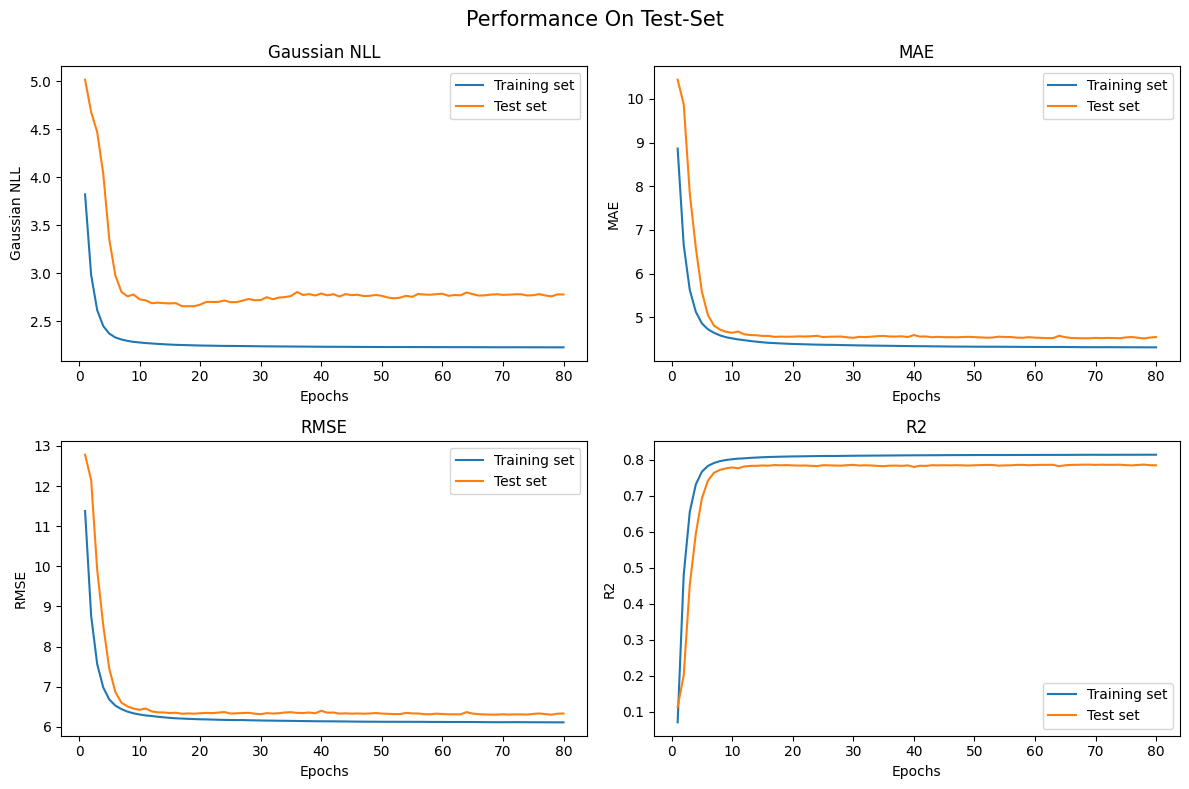

In [11]:
factor =  0.4
st = 0
metrics = load_dict(metrics_path, 'final_model_test_metrics')
smooth_loss_train = smooth_curve(metrics['train_nll_loss_ls'][st:], factor)
smooth_loss_val = smooth_curve(metrics['eval_nll_loss_ls'][st:], factor)
smooth_mae_train = smooth_curve(metrics['train_mae_ls'][st:], factor)
smooth_mae_val = smooth_curve(metrics['eval_mae_ls'][st:], factor)
smooth_mse_train = smooth_curve(metrics['train_rmse_ls'][st:], factor)
smooth_mse_val = smooth_curve(metrics['eval_rmse_ls'][st:], factor)
smooth_r2_train = smooth_curve(metrics['train_r2_ls'][st:], factor)
smooth_r2_val = smooth_curve(metrics['eval_r2_ls'][st:], factor)

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
fig.suptitle('Performance On Test-Set', fontsize=15)
# Plot the first metric on the top-left subplot
axs[0, 0].plot(range(1, len(smooth_loss_train) + 1), smooth_loss_train, label='Training set')
axs[0, 0].plot(range(1, len(smooth_loss_val) + 1), smooth_loss_val, label='Test set')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Gaussian NLL')
axs[0, 0].set_title('Gaussian NLL')
axs[0, 0].legend()
# Plot the second metric on the top-right subplot
axs[0, 1].plot(range(1, len(smooth_mae_train) + 1), smooth_mae_train,label='Training set')
axs[0, 1].plot(range(1, len(smooth_mae_val) + 1), smooth_mae_val, label='Test set')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].legend()
# Plot the third metric on the bottom-left subplot
axs[1, 0].plot(range(1, len(smooth_mse_train) + 1), smooth_mse_train,label='Training set')
axs[1, 0].plot(range(1, len(smooth_mse_val) + 1), smooth_mse_val, label='Test set')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].set_title('RMSE')
axs[1, 0].legend()
# Plot the fourth metric on the bottom-right subplot
axs[1, 1].plot(range(1, len(smooth_r2_train) + 1), smooth_r2_train,label='Training set')
axs[1, 1].plot(range(1, len(smooth_r2_val) + 1), smooth_r2_val, label='Test set')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('R2')
axs[1, 1].set_title('R2')
axs[1, 1].legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.savefig(plots_path + "/test_set_metrics.pdf")
plt.show()

## Plot Probabilistv Forecasting Forecast 

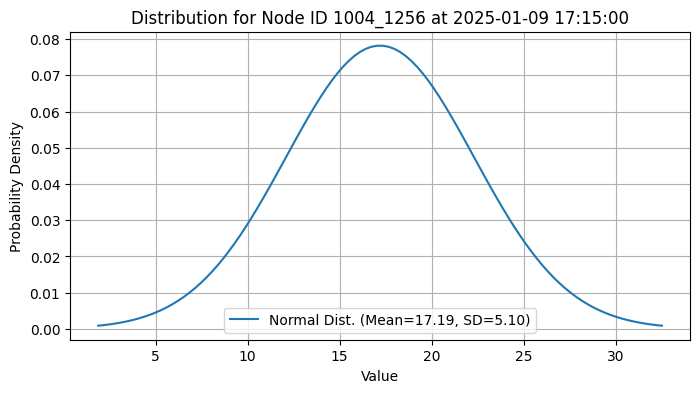

In [7]:
forecast_df = pd.read_csv(join(output_path, "interm_avg_speed_forecasts.csv"), encoding='utf-8', sep=',')


# Load your DataFrame, here assumed to already be loaded as avg_speed_forecasts_df

# Define the desired range from the mean to cover 95% of the data
# Change this value to adjust the tightness of the distribution around the mean
desired_range = 10  # This means ±5 units from the mean

# Calculate the new standard deviation
new_std_dev = desired_range / 1.96

# Calculate the new log variance
new_log_var = np.log(new_std_dev**2)

# Apply the new log variance to the DataFrame
forecast_df['log_var'] = new_log_var



node_id = '1004_1256'  # Example node ID
timestamp = '2025-01-09 17:15:00'  # Example timestamp

plot_specific_distribution(forecast_df, node_id, timestamp, plots_path)



In [ ]:
smooth_loss_train = smooth_curve(metrics['train_nll_loss_ls'][st:], factor)
smooth_loss_val = smooth_curve(metrics['eval_nll_loss_ls'][st:], factor)
smooth_mae_train = smooth_curve(metrics['train_mae_ls'][st:], factor)
smooth_mae_val = smooth_curve(metrics['eval_mae_ls'][st:], factor)
smooth_mse_train = smooth_curve(metrics['train_rmse_ls'][st:], factor)
smooth_mse_val = smooth_curve(metrics['eval_rmse_ls'][st:], factor)
smooth_r2_train = smooth_curve(metrics['train_r2_ls'][st:], factor)
smooth_r2_val = smooth_curve(metrics['eval_r2_ls'][st:], factor)

In [38]:
metrics = load_dict(metrics_path, 'experiment_features_lag_features')

In [39]:
print(metrics['eval_nll_loss_ls'][-1])
print(metrics['eval_mae_ls'][-1])
print(metrics['eval_rmse_ls'][-1])
print(metrics['eval_r2_ls'][-1])


2.2957484883646813
4.4911887256560785
6.314458260382375
0.7951968056924882


In [ ]:
nll_loss = 2.295
mae_ls = 4.491
rmse_ls =6.314
r2_ls = 0.795